In [8]:
import pandas as pd
import spacy
import math
import nltk
import string
import numpy as np
import seaborn as sns
#from wordcloud import WordCloud
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

nlp = spacy.load('pt_core_news_md')

stop_words = spacy.lang.pt.stop_words.STOP_WORDS
punctuations = string.punctuation

In [14]:
df = pd.read_excel("..\..\Dataset\LiveTimRA.xlsx")
df = df[['Id','Descricao', 'Nota']]
df = df.dropna()

In [15]:
def plot_cm(conf_matrix):
    sns.set(font_scale=1.4, color_codes=True, palette="deep")
    sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d", cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")
    plt.show()

In [11]:
def spacy_tokenizer(sentence, removeTopWords, lemmatize):

    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(str(sentence))

    # Lemmatizing each token and converting each token into lowercase
    if lemmatize:
        mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    #mytokens = [ word.lemma_.lower().strip() for word in mytokens ]

    # Removing stop words
    if removeTopWords:
        mytokens = [word for word in mytokens if word not in stop_words]

    # Removing punctuations
    mytokens = [str(word) for word in mytokens if str(word) not in punctuations]
    # return preprocessed list of tokens
    return mytokens


In [12]:
def removeChars(dataFrame, hashtags):
    # Remove @ tags

    dataFrame.comment = dataFrame.comment.str.replace(r'(@\w*)', '', regex=True)

    # Remove URL
    dataFrame.comment = dataFrame.comment.str.replace(r"http\S+", "", regex=True)

    # Remove # tag
    if (hashtags):
        dataFrame.comment = dataFrame.comment.str.replace(r'#\w+', "", regex=True)
    # comp_df.tweet = comp_df.tweet.str.replace(r'#+',"")

    # Remove all non-character
    # comp_df.tweet = comp_df.tweet.str.replace(r"[^a-zA-Z ]","")

    # Remove extra space
    dataFrame.comment = dataFrame.comment.str.replace(r'( +)', " ", regex=True)
    dataFrame.comment = dataFrame.comment.str.strip()

    # Change to lowercase
    dataFrame.comment = dataFrame.comment.str.lower()

*******************************
Run sendo executada com o dataSet 'ReclameAqui - TIM' que contem 3451 texts
Dos quais, 3125 São para treinamento e 326 são para teste
Os Argumentos dessa run são, RemoverTopWords: True Remover HashTags: False Lematizar: False
*******************************
As 5 palavras mais comuns do BOW são:
[('que', 16616), ('de', 15670), ('o', 15521), ('e', 15510), ('a', 15200)]
[ 8. 10.  7.  0.  2.  6.  9.  5.  1.  4.  3.]
As 5 palavras mais comuns do Label 0.0 são:
[('que', 1654), ('de', 1636), ('o', 1619), ('e', 1592), ('a', 1578)]
As 5 palavras mais comuns do Label 1.0 são:
[('que', 628), ('de', 586), ('o', 581), ('e', 580), ('a', 548)]
As 5 palavras mais comuns do Label 2.0 são:
[('que', 597), ('o', 522), ('e', 521), ('de', 519), ('a', 465)]
As 5 palavras mais comuns do Label 3.0 são:
[('que', 773), ('e', 769), ('o', 744), ('de', 710), ('a', 708)]
As 5 palavras mais comuns do Label 4.0 são:
[('que', 728), ('o', 718), ('e', 713), ('de', 640), ('a', 626)]
As 5 pa

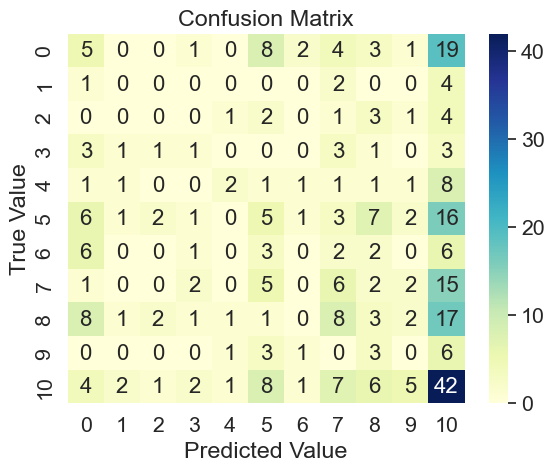

Resultado do Cross Validation
0.16863999999999998


In [16]:
removeTopWords = True
hashtags = False
lemmatize = False

msk = np.random.rand(len(df)) < 0.9

trainDf = df[msk].copy()
testDf = df[~msk].copy()

print("*******************************")
print("Run sendo executada com o dataSet 'ReclameAqui - TIM' que contem " + str(len(df)) + " texts")
print("Dos quais, " + str(len(trainDf)) + " São para treinamento e " + str(len(testDf)) + " são para teste")
print("Os Argumentos dessa run são, RemoverTopWords: " + str(removeTopWords) + " Remover HashTags: " + str(hashtags) + " Lematizar: " + str(lemmatize))
print("*******************************")

trainDf.loc[:, 'is_test'] = 0
testDf.loc[:, 'is_test'] = 1

comp_df = pd.concat([trainDf, testDf])
comp_df.reset_index(drop=True, inplace=True)

comp_df = comp_df[['Descricao', 'Nota', 'is_test']]
comp_df.columns = ['comment', 'label', 'is_test']

comp_df['label'] = comp_df.label.replace('S', 1)
comp_df['label'] = comp_df.label.replace(math.nan, 0)

removeChars(comp_df, hashtags)

comp_df['corpus'] = [spacy_tokenizer(comment, removeTopWords, lemmatize) for comment in comp_df.comment]

count = Counter()

for cp in comp_df.corpus:
    count += Counter(cp)

print("As 5 palavras mais comuns do BOW são:")
print(count.most_common(5))

print(comp_df.label.unique())
for label in sorted(comp_df.label.unique()):
    corpusInLabel = comp_df.corpus[comp_df.label == label]

    count = Counter()
    for cp in corpusInLabel:
        count += Counter(cp)

    print("As 5 palavras mais comuns do Label " + str(label) + " são:")
    print(count.most_common(5))

print("As frequencias dos Labels são as seguintes:")
print(comp_df.label.value_counts())

comp_df.corpus = comp_df.apply(lambda x: " ".join(x.corpus), axis=1)
print(comp_df.head())

x_train = comp_df.corpus[comp_df.is_test == 0]
y_train = comp_df.label[comp_df.is_test == 0]
x_test = comp_df.corpus[comp_df.is_test == 1]
y_test = comp_df.label[comp_df.is_test == 1]

print("shape do treinamento")
print(x_train.shape)
print("shape do teste")
print(x_test.shape)

freq_vector = CountVectorizer(min_df=2, ngram_range=(1, 2)).fit(comp_df.corpus)

x_train = freq_vector.transform(x_train)
x_test = freq_vector.transform(x_test)

classifier = LogisticRegression(max_iter=500)

classifier.fit(x_train, y_train)

y_pred_train = classifier.predict(x_train)
print("FScore do classificador em cima do treinamento")
print(precision_recall_fscore_support(y_train, y_pred_train, average='macro', zero_division=True))

y_pred_test = classifier.predict(x_test)
print("FScore do classificador em cima do Teste")
print(precision_recall_fscore_support(y_test, y_pred_test, average='macro', zero_division=True))

cm = confusion_matrix(y_test, y_pred_test)
print("Matriz de confusão")
plot_cm(cm)

print("Resultado do Cross Validation")
print(cross_val_score(LogisticRegression(random_state=42), x_train, y_train, cv=5, verbose=0, n_jobs=-1).mean())